# Substack Article Text Analysis
Here we analyze substack article text from various blogs to identify characteristics associated with engagement. We also perform unsupervised topic modeling on the text using Latent Dirichlet Allocation (LDA) to identify if there are certain topics more stongly associated with engagement.

In [33]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from gensim.models import Phrases
import gensim.corpora as corpora
from gensim.models import LdaModel
from ast import literal_eval
from scipy.stats import pearsonr
from multiprocessing import Pool
import numpy as np
import statsmodels.stats.multitest as smm

### Identifying Variables Associated with Engagement

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('substack_database.db')

# Query to select rows where tokens is not null
query = '''
    SELECT *
    FROM article_data
    WHERE tokens IS NOT NULL
'''

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

In [3]:
# test if variables are significantly associated with reactions and comments (a surrogate for views)

x_variables = [
    'wordcount',
    'polarity',
    'objectivity',
    'number_of_questions',
    'fk_grade_level',
    'gunning_fog_index',
    'reading_time',
    'p_elem_counts',
    'a_elem_counts',
    'img_elem_counts',
    'ul_elem_counts',
    'li_elem_counts',
    'video_elem_counts',
    'br_elem_counts',
]

coefficients = []
p_values = []

for x_variable in x_variables:
    # Calculate the Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = stats.pearsonr(df['comment_count'] + df['reaction_count'], df[x_variable])
    coefficients.append(correlation_coefficient)
    p_values.append(p_value)

stats_df = pd.DataFrame()
stats_df['variable'] = x_variables
stats_df['coefficient'] = coefficients
stats_df['p_value'] = [round(x, 4) for x in p_values]
stats_df

,variable,coefficient,p_value
0,wordcount,-0.096304,0.0012
1,polarity,-0.145529,0.0000
2,objectivity,-0.050706,0.0896
3,number_of_questions,-0.048676,0.1032
4,fk_grade_level,-0.138023,0.0000
5,gunning_fog_index,-0.181597,0.0000
6,reading_time,-0.101503,0.0007
7,p_elem_counts,0.090353,0.0025
8,a_elem_counts,-0.131413,0.0000
9,img_elem_counts,-0.048710,0.1029


In [4]:
# remove non-significant values, interpret results....
stats_df[stats_df.p_value < 0.05].sort_values(by="coefficient")

,variable,coefficient,p_value
5,gunning_fog_index,-0.181597,0.0000
13,br_elem_counts,-0.148797,0.0000
1,polarity,-0.145529,0.0000
4,fk_grade_level,-0.138023,0.0000
8,a_elem_counts,-0.131413,0.0000
11,li_elem_counts,-0.109198,0.0002
6,reading_time,-0.101503,0.0007
0,wordcount,-0.096304,0.0012
10,ul_elem_counts,-0.071684,0.0163
7,p_elem_counts,0.090353,0.0025


Interpretation:
- Overall it seems that shorter articles (ower reading time, elements, shorter wordcount) with higher readability (lower gunning fog index, lower Flesch-Kincaid readability levels) have more viewership
- More negative articles are associated with more viewership and engagement (polarity), thats a bit dark....

<AxesSubplot:xlabel='fk_grade_level', ylabel='total_engagement'>

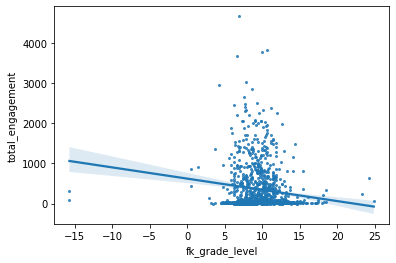

In [5]:
df["total_engagement"] = df['comment_count'] + df['reaction_count']

sns.regplot(data=df, x="fk_grade_level", y="total_engagement", scatter_kws={'s': 4})

In [6]:
# get the source for each article (blog)
blog_urls = []
for url in df['canonical_url']:
    domain_parts = url.split('.com')
    if len(domain_parts) > 0:
        blog_urls.append(domain_parts[0] + ".com")
    else:
        blog_urls.append(None)

df['blog_url'] = blog_urls
len(set(blog_urls)) # 44 unique blogs

44

In [7]:
# im guessing that the blog source has a bigger contribution than the other variables...it is.

# Assuming 'total_engagement' is your dependent variable (y)
y = df['total_engagement']

# Selecting independent variables (X)
X = df[['blog_url', 'wordcount', 'polarity', 'objectivity', 'number_of_questions',
        'fk_grade_level', 'gunning_fog_index', 'reading_time', 'p_elem_counts',
        'a_elem_counts', 'img_elem_counts', 'ul_elem_counts', 'li_elem_counts',
        'video_elem_counts', 'br_elem_counts']]

# Encoding the categorical variable 'blog_url'
X['blog_url'] = pd.Categorical(X['blog_url'])
X = pd.get_dummies(X, columns=['blog_url'], drop_first=True)

# Adding a constant term (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get a summary of the model
summary = model.summary()

print(summary)


                            OLS Regression Results                            
Dep. Variable:       total_engagement   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     27.60
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.31e-170
Time:                        20:48:39   Log-Likelihood:                -8196.9
No. Observations:                1122   AIC:                         1.651e+04
Df Residuals:                    1064   BIC:                         1.680e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Topic Modeling with LDA

In [20]:
documents = [literal_eval(tokens) for tokens in df['tokens']] # convert the strings to proper lists
documents = [[token for token in document if len(token) > 2] for document in documents] # remove any tokens that are one, two characters or empty characters

dictionary = corpora.Dictionary(documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(document) for document in documents]

In [22]:
# Create the LDA model

num_topics = 6  
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

# Print the topics and their top words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.010*"trump" + 0.008*"political" + 0.005*"power" + 0.005*"republican" + 0.005*"war"')
(1, '0.007*"think" + 0.007*"book" + 0.006*"music" + 0.006*"thats" + 0.005*"really"')
(2, '0.010*"colorado" + 0.009*"news" + 0.009*"china" + 0.008*"media" + 0.008*"local"')
(3, '0.009*"media" + 0.009*"covid" + 0.009*"twitter" + 0.008*"book" + 0.007*"cookbook"')
(4, '0.018*"beauty" + 0.008*"war" + 0.007*"think" + 0.007*"skin" + 0.006*"russia"')
(5, '0.007*"back" + 0.006*"know" + 0.005*"going" + 0.005*"never" + 0.005*"last"')


In [15]:
# Assign a topic to each article

# Create a list to store the topic assignments for each document
document_topics = []

# Infer topic distributions for each document
for doc_bow in corpus:
    # Get the topic distribution for the document
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    
    # Sort the topics by probability in descending order
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    
    # Get the most probable topic (the first topic in the sorted list)
    most_probable_topic = doc_topics[0]
    
    # Append the topic ID to the list of document topics
    document_topics.append(most_probable_topic[0])

# Add the document topics as a new column in your DataFrame
df['topic'] = document_topics

# Define a mapping from numbers to labels, create some names based on the top 5 words
topic_mapping = {
    0: "Arts and Entertainmen",
    1: "Arts and Entertainment",
    2: "Beauty and Wellness",
    3: "Media and Politics",
    4: "Opinions and Perspectives"
}

# Use the 'replace' method to map the numbers with labels
df['topic_name'] = df['topic'].replace(topic_mapping)


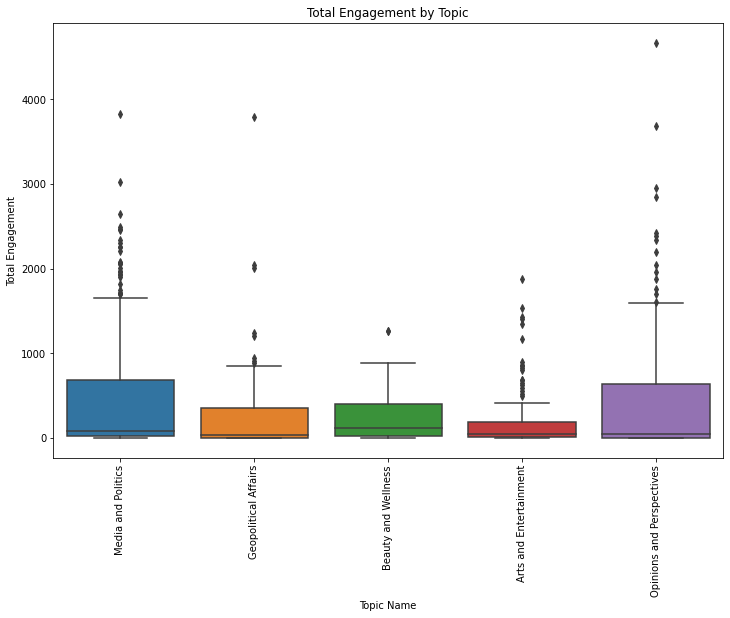

In [16]:
# Are any of the topics associated with significantly higher total engagement than the others?

# Visualize the topics against one another....

plt.figure(figsize=(12, 8))  
sns.boxplot(x='topic_name', y='total_engagement', data=df)

# Set labels and title
plt.xlabel('Topic Name')
plt.ylabel('Total Engagement')
plt.title('Total Engagement by Topic')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [17]:
# Run an ANOVA with a Tukey HSD to determine if any are significantly greater
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit the ANOVA model
model = ols('total_engagement ~ topic_name', data=df).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table to check for significance
print("ANOVA Table:\n", anova_table)

# Perform the Tukey post-hoc test
tukey_result = pairwise_tukeyhsd(df['total_engagement'], df['topic_name'])

# Print the Tukey test summary
print("\nTukey Post-Hoc Test:\n", tukey_result)


ANOVA Table:
                   sum_sq      df          F        PR(>F)
topic_name  1.343440e+07     4.0  10.797913  1.368150e-08
Residual    3.474335e+08  1117.0        NaN           NaN

Tukey Post-Hoc Test:
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
        group1                   group2          meandiff p-adj    lower    upper   reject
------------------------------------------------------------------------------------------
Arts and Entertainment       Beauty and Wellness  70.9192 0.7808  -97.8747 239.7132  False
Arts and Entertainment      Geopolitical Affairs 108.7907 0.4789  -73.6546 291.2359  False
Arts and Entertainment        Media and Politics 274.2931    0.0  141.9305 406.6557   True
Arts and Entertainment Opinions and Perspectives 247.7074    0.0  105.2575 390.1573   True
   Beauty and Wellness      Geopolitical Affairs  37.8714 0.9843 -157.5881  233.331  False
   Beauty and Wellness        Media and Politics 203.3739  0.

In [18]:
# alternately, try to look at the pearson correlation 

# Calculate Pearson correlation for each unique topic_name
correlation_data = []
unique_topics = df['topic_name'].unique()

for topic in unique_topics:
    df['has_topic'] = (df['topic_name'] == topic).astype(int)
    coefficient, p_value = pearsonr(df['total_engagement'], df['has_topic'])
    correlation_data.append([topic, coefficient, round(p_value, 4)])

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data, columns=['topic_name', 'coefficient', 'p_value'])

correlation_df


,topic_name,coefficient,p_value
0,Media and Politics,0.126897,0.0000
1,Geopolitical Affairs,-0.040137,0.1791
2,Beauty and Wellness,-0.071358,0.0168
3,Arts and Entertainment,-0.145283,0.0000
4,Opinions and Perspectives,0.069161,0.0205


## Keywords Associated w/ Engagement

In [29]:
# Get all words in the dictionary 
all_words = list(dictionary.token2id.keys())
all_words[0:10]

['apple',
 'available',
 'conversation',
 'coverage',
 'day',
 'discuss',
 'early',
 'empire',
 'episode',
 'essential']

In [30]:
# find out how many words we are going to analyze
len(all_words)

2911

In [31]:
# Multiprocessing function to calculate statistics for a given word
# Here we use a Mann Whitney U test to compare whether the word is associated with total_engagement
def calculate_statistics(word):
    try:
        negative_counts = []
        positive_counts = []
        negative_mean = []
        positive_mean = []
        p_values = []
        coefficients = []

        # Function to check if the input string is in a row
        def is_input_in_row(row):
            return word in row['tokens']

        df['is_in_df'] = df.apply(is_input_in_row, axis=1)
        positive_subset = df[df.is_in_df]
        negative_subset = df[~df.is_in_df]

        negative_counts.append(len(negative_subset))
        positive_counts.append(len(positive_subset))


        negative_array = negative_subset['total_engagement']
        positive_array = positive_subset['total_engagement']
        negative_mean.append(negative_array.mean())
        positive_mean.append(positive_array.mean())

        statistic, p_value = stats.mannwhitneyu(positive_array, negative_array)
        p_values.append(p_value)
        coefficients.append(statistic)

        return {
            'word': word,
            'negative_counts': negative_counts[0],
            'positive_counts': positive_counts[0],
            'negative_mean': negative_mean[0],
            'positive_mean': positive_mean[0],
            'p_value': p_values[0],
            'coefficient': coefficients[0]
        }
    except:
        return {
            'word': word,
            'negative_counts': None,
            'positive_counts': None,
            'negative_mean': None,
            'positive_mean': None,
            'p_value': None,
            'coefficient': None
        }


In [35]:
# these calculations can potentially take awhile so we'll use multiprocessing to parallelize it.....

pool = Pool(processes=6)  # You can adjust the number of processes as needed

# Calculate statistics for each word in parallel
results = pool.map(calculate_statistics, all_words)
pool.close()
pool.join()

# Create a DataFrame with the results
stats_results = pd.DataFrame(results)

# remove invalid values
# Check for NaN values
nan_values = np.isnan(stats_results['p_value'])

# Check for Inf values
inf_values = np.isinf(stats_results['p_value'])

stats_results = stats_results[~nan_values][~inf_values]

# Run BH correction on the 'p_value' column
rejected, corrected_p_values, _, _ = smm.multipletests(np.sort(stats_results['p_value']), method='fdr_bh')

# Add the BH-corrected p-values and 'rejected' column to the DataFrame
stats_results['fdr'] = corrected_p_values
stats_results['rejected'] = rejected
stats_results['effect_size'] = stats_results['positive_mean'] / stats_results['negative_mean']
stats_results.head()


,word,negative_counts,positive_counts,negative_mean,positive_mean,p_value,coefficient,fdr,rejected,effect_size
0,apple,957,165,390.878788,90.157576,1.108336e-07,58554.5,2.782733e-10,True,0.230654
1,available,929,193,363.236814,266.839378,6.579430e-01,87835.0,1.257111e-09,True,0.734615
2,conversation,935,187,381.167914,174.090909,5.238596e-07,67133.5,2.796676e-09,True,0.456730
3,coverage,1034,88,350.866538,297.170455,1.957749e-02,38686.0,2.796676e-09,True,0.846962
4,day,473,649,339.126850,352.141757,7.134229e-02,143826.0,3.572513e-09,True,1.038378


In [37]:
# what keywords have the highest effect sizes?

# remove insignificant keywords, look at the top 50 significant keywords with the largest effect sizes 
stats_results[stats_results.fdr < 0.05].sort_values(by="effect_size", ascending=False)[0:50]

# ...pretty obviously all political ones, thats kind of interesting. I suspect that is not unrelated related to why negative writing is more popuar....

,word,negative_counts,positive_counts,negative_mean,positive_mean,p_value,coefficient,fdr,rejected,effect_size
285,senator,1068,54,322.614232,822.129630,7.860963e-06,39215.0,0.010583,True,2.548337
38,republican,924,198,291.913420,602.116162,1.061313e-04,107509.5,0.000009,True,2.062653
428,gains,1090,32,337.072477,673.062500,1.097056e-02,22034.5,0.032273,True,1.996789
228,trump,874,248,284.308924,566.375000,6.757246e-05,126316.5,0.004751,True,1.992111
34,nomination,1092,30,337.791209,669.300000,9.233081e-01,16549.0,0.000009,True,1.981401
122,contrast,1081,41,335.514339,640.390244,9.642779e-02,25545.5,0.000655,True,1.908682
80,democratic,924,198,301.705628,556.419192,1.802361e-02,101259.5,0.000140,True,1.844245
413,democracy,987,135,314.697062,580.303704,6.956346e-05,80664.5,0.029800,True,1.844007
291,wage,1035,87,326.071498,591.528736,9.503106e-06,57873.0,0.011571,True,1.814107
73,billion,959,163,310.183525,561.233129,2.805623e-06,96070.0,0.000109,True,1.809358
